# 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.5)

SEED = 42

In [2]:
train_q = pd.read_excel("data/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
train_c = pd.read_excel("data/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
test_q = pd.read_excel("data/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_c = pd.read_excel("data/TEST/TEST_CATEGORICAL_METADATA.xlsx")

train_combined = pd.merge(train_q, train_c, on='participant_id', how='left').set_index("participant_id")
test_combined = pd.merge(test_q, test_c, on='participant_id', how='left').set_index("participant_id")

labels = pd.read_excel("data/TRAIN/TRAINING_SOLUTIONS.xlsx").set_index('participant_id')

y_adhd = labels['ADHD_Outcome']
y_sex = labels['Sex_F']

train_combined = train_combined.sort_index()
test_combined = test_combined.sort_index()
labels = labels.sort_index()
assert all(train_combined.index == labels.index), "error"

In [3]:
train_combined.head()

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,MRI_Track_Age_at_Scan,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,,,,,,,,,,,,,
00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,...,14.274127,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,...,NaN,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,...,13.463381,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,...,9.572553,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,...,6.654574,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


In [4]:
print(train_combined.columns)
print(len(train_combined.columns))

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')
27


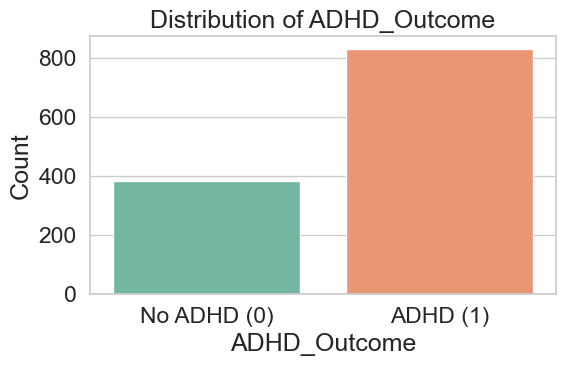

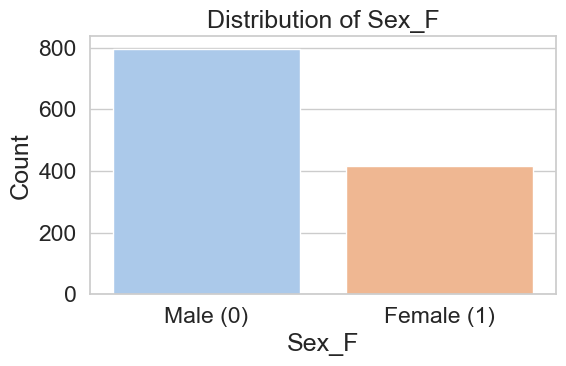

In [5]:
label_df = labels.copy()

# Plot: ADHD_Outcome
plt.figure(figsize=(6, 4))
sns.countplot(x=label_df["ADHD_Outcome"], palette="Set2")
plt.title("Distribution of ADHD_Outcome")
plt.xticks([0, 1], ['No ADHD (0)', 'ADHD (1)'])
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot: Sex_F
plt.figure(figsize=(6, 4))
sns.countplot(x=label_df["Sex_F"], palette="pastel")
plt.title("Distribution of Sex_F")
plt.xticks([0, 1], ['Male (0)', 'Female (1)'])
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Data Preprocessing

This is some explanation of feature present in the dataset

## 2.1 Numerical features: Total of 18 features
+ EHQ_EHQ_Total: laterality index score (float) || -100 = 10th left, −28 ≤ LI < 48 = middle, 100 = 10th right"
+ ColorVision_CV_Score: color vision test score (int)
+ MRI_Track_Age_at_Scan: Age at time of MRI scan (float)

### ALABAMA PARENTING QUESTIONAIRE - PARENT REPORT (INT)
+ APQ_P_APQ_P_CP: Reflects the frequency or severity of corporal punishment used by parents
+ APQ_P_APQ_P_ID: Measures inconsistency in parental discipline
+ APQ_P_APQ_P_INV: Indicates the level of parental involvement in the child’s life
+ APQ_P_APQ_P_OPD: Other Discipline Practices Score (Not factored into total score but provides item level information)
+ APQ_P_APQ_P_PM: Reflects how well a parent monitors and supervises their child
+ APQ_P_APQ_P_PP: Captures the extent of positive reinforcement and supportive parenting

### Strength and Difficulties Questionnaire (INT)
+ SDQ_SDQ_Conduct_Problems: Measures behavioral issues related to rule-breaking or aggression (higher score = more prone to ADHD)
+ SDQ_SDQ_Difficulties_Total: A composite measure summarizing overall difficulties across several behavioral domains
+ SDQ_SDQ_Emotional_Problems: Focuses on internal emotional difficulties such as anxiety or depression (social related)
+ SDQ_SDQ_Externalizing: Captures outward-directed behaviors such as hyperactivity, impulsivity, and conduct issues
+ SDQ_SDQ_Generating_Impact: This might reflect the overall impact of the child’s behavioral problems on their social and academic life
+ SDQ_SDQ_Hyperactivity: Directly measures the hyperactive and impulsive behaviors central to many ADHD diagnoses (HIGHLY CORRELATED FEATURE)
+ SDQ_SDQ_Internalizing: Reflects inward-focused behaviors such as social withdrawal and anxiety
+ SDQ_SDQ_Peer_Problems: Assesses difficulties in interacting with peers
+ SDQ_SDQ_Prosocial: Evaluates positive social behaviors like empathy and cooperation

## 2.2 Categorical Features Visualization: Total of 10 features (already label encoded)

+ Basic_Demos_Enroll_Year: the year when the participant enrolled in the study (int) (Nomial)
+ Basic_Demos_Study_Site: Location/site where the subject was assessed (Nomial)
+ PreInt_Demos_Fam_Child_Ethnicity: Ethnic background of the child (nomial)
+ PreInt_Demos_Fam_Child_Race: Race of the child (nomial)
+ MRI_Track_Scan_Location: Where the MRI was performed (nomial)
+ Barratt_Barratt_P1_Edu: education of the parent 1 (ORDINAL)
+ Barratt_Barratt_P1_Occ: occupation of parent 1 (ORDINAL)
+ Barratt_Barratt_P2_Edu: education of the parent 2 (ORDINAL)
+ Barratt_Barratt_P2_Occ: occupation of parent 2 (ORDINAL)
+ Laterality_Category: Categorical brain lateralization: left, middle, or right

## 2.3 fMRI Connectome Matrices
+ Dimensionality Reduction: Apply techniques like Principal Component Analysis (PCA), Independent Component Analysis (ICA), or Uniform Manifold Approximation and Projection (UMAP) to the flattened connectome matrices before applying other feature selection methods or feeding them into models like Logistic Regression or standard Tree-based algorithms. Deep Learning models might handle the high dimensionality better directly.

In [6]:
numerical_features = [
    'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
    'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'
]
print(len(numerical_features))

18


In [7]:
numerical_features_df = train_combined[numerical_features]

def nan_summary(df, name):
    print(f"---- {name} NAN SUMMARY ----")
    print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False), '\n')

nan_summary(numerical_features_df, "TRAIN NUMERICAL FEATURES")

---- TRAIN NUMERICAL FEATURES NAN SUMMARY ----
MRI_Track_Age_at_Scan         29.678483
ColorVision_CV_Score           1.896125
EHQ_EHQ_Total                  1.071723
APQ_P_APQ_P_ID                 0.989283
APQ_P_APQ_P_INV                0.989283
APQ_P_APQ_P_OPD                0.989283
APQ_P_APQ_P_PM                 0.989283
APQ_P_APQ_P_PP                 0.989283
APQ_P_APQ_P_CP                 0.989283
SDQ_SDQ_Conduct_Problems       0.741962
SDQ_SDQ_Emotional_Problems     0.741962
SDQ_SDQ_Externalizing          0.741962
SDQ_SDQ_Generating_Impact      0.741962
SDQ_SDQ_Hyperactivity          0.741962
SDQ_SDQ_Internalizing          0.741962
SDQ_SDQ_Peer_Problems          0.741962
SDQ_SDQ_Prosocial              0.741962
SDQ_SDQ_Difficulties_Total     0.741962
dtype: float64 



In [8]:
# num feature 1 
feature_1 = 'EHQ_EHQ_Total'

median_value = train_combined[feature_1].median()
train_combined[feature_1] = train_combined[feature_1].fillna(median_value)
print(f"Filled NaN with median value: {median_value}")

median_test_value = test_combined[feature_1].median()
test_combined[feature_1] = test_combined[feature_1].fillna(median_test_value)
print(f"Filled NaN with median value: {median_test_value}")

def categorize_laterality(li):
    if -110 <= li <= -28:
        return "Left-Lateralized"
    elif -28 < li <= 47:
        return 'Middle'
    elif 47 < li <= 110:
        return 'Right-Lateralized'

train_combined['Laterality_Category'] = train_combined['EHQ_EHQ_Total'].apply(categorize_laterality)
test_combined['Laterality_Category'] = test_combined['EHQ_EHQ_Total'].apply(categorize_laterality)

Filled NaN with median value: 77.8
Filled NaN with median value: 73.37


In [9]:
# num feature 2
train_combined['ColorVision_CV_Score'].fillna(14, inplace=True)
print("Missing values after fill:", train_combined["ColorVision_CV_Score"].isna().sum())

test_combined['ColorVision_CV_Score'].fillna(14, inplace=True)
print("Missing values after fill:", test_combined["ColorVision_CV_Score"].isna().sum())

Missing values after fill: 0
Missing values after fill: 0


In [10]:
apq_features = [
    'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 
    'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 
]

for feature in apq_features:
    median_value = train_combined[feature].median()
    train_combined[feature] = train_combined[feature].fillna(median_value)
    print(f"{feature} - Filled train NaN with median: {median_value}")
    
    # For test dataset
    median_test_value = test_combined[feature].median()
    test_combined[feature] = test_combined[feature].fillna(median_test_value)
    print(f"{feature} - Filled test NaN with median: {median_test_value}")

APQ_P_APQ_P_CP - Filled train NaN with median: 3.0
APQ_P_APQ_P_CP - Filled test NaN with median: 3.0
APQ_P_APQ_P_ID - Filled train NaN with median: 13.0
APQ_P_APQ_P_ID - Filled test NaN with median: 13.0
APQ_P_APQ_P_INV - Filled train NaN with median: 40.0
APQ_P_APQ_P_INV - Filled test NaN with median: 40.0
APQ_P_APQ_P_OPD - Filled train NaN with median: 18.0
APQ_P_APQ_P_OPD - Filled test NaN with median: 17.0
APQ_P_APQ_P_PM - Filled train NaN with median: 16.0
APQ_P_APQ_P_PM - Filled test NaN with median: 15.0
APQ_P_APQ_P_PP - Filled train NaN with median: 26.0
APQ_P_APQ_P_PP - Filled test NaN with median: 25.0


In [11]:
# SDQ features
sdq_features = [
    'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Emotional_Problems', 
    'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
    'SDQ_SDQ_Difficulties_Total'
]

for feature in sdq_features:
    median_value = train_combined[feature].median()
    train_combined[feature] = train_combined[feature].fillna(median_value)
    print(f"{feature} - Filled train NaN with median: {median_value}")
    
    median_test_value = test_combined[feature].median()
    test_combined[feature] = test_combined[feature].fillna(median_test_value)
    print(f"{feature} - Filled test NaN with median: {median_test_value}")

SDQ_SDQ_Conduct_Problems - Filled train NaN with median: 2.0
SDQ_SDQ_Conduct_Problems - Filled test NaN with median: 1.0
SDQ_SDQ_Emotional_Problems - Filled train NaN with median: 2.0
SDQ_SDQ_Emotional_Problems - Filled test NaN with median: 2.0
SDQ_SDQ_Externalizing - Filled train NaN with median: 8.0
SDQ_SDQ_Externalizing - Filled test NaN with median: 7.0
SDQ_SDQ_Generating_Impact - Filled train NaN with median: 4.0
SDQ_SDQ_Generating_Impact - Filled test NaN with median: 4.0
SDQ_SDQ_Hyperactivity - Filled train NaN with median: 6.0
SDQ_SDQ_Hyperactivity - Filled test NaN with median: 6.0
SDQ_SDQ_Internalizing - Filled train NaN with median: 4.0
SDQ_SDQ_Internalizing - Filled test NaN with median: 4.0
SDQ_SDQ_Peer_Problems - Filled train NaN with median: 2.0
SDQ_SDQ_Peer_Problems - Filled test NaN with median: 1.0
SDQ_SDQ_Prosocial - Filled train NaN with median: 8.0
SDQ_SDQ_Prosocial - Filled test NaN with median: 8.0
SDQ_SDQ_Difficulties_Total - Filled train NaN with median: 12.0


In [12]:
numeric_data = train_combined[numerical_features].copy()
imputer = IterativeImputer(estimator=LassoCV(random_state=SEED), max_iter=100, random_state=SEED)

numeric_data_imputed = pd.DataFrame(
    imputer.fit_transform(numeric_data), 
    columns=numerical_features, 
    index=numeric_data.index
)
train_combined['MRI_Track_Age_at_Scan'] = numeric_data_imputed['MRI_Track_Age_at_Scan']

test_numeric_data = test_combined[numerical_features].copy()
test_numeric_data_imputed = pd.DataFrame(
    imputer.transform(test_numeric_data),
    columns=numerical_features,
    index=test_numeric_data.index
)
test_combined['MRI_Track_Age_at_Scan'] = test_numeric_data_imputed['MRI_Track_Age_at_Scan']

## Now we handle categorical features

In [13]:
categorical_features = [
    'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
    'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
    'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
    'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P2_Occ', 'Laterality_Category',
]

print(len(categorical_features))   

10


In [14]:
categorical_features_df = train_combined[categorical_features]

nan_summary(categorical_features_df, "TRAIN CATEGORICAL FEATURES")

---- TRAIN CATEGORICAL FEATURES NAN SUMMARY ----
Barratt_Barratt_P2_Occ              18.301731
Barratt_Barratt_P2_Edu              16.323166
PreInt_Demos_Fam_Child_Race          4.451772
PreInt_Demos_Fam_Child_Ethnicity     3.544930
Barratt_Barratt_P1_Occ               2.555647
Barratt_Barratt_P1_Edu               1.236603
MRI_Track_Scan_Location              0.247321
Basic_Demos_Enroll_Year              0.000000
Basic_Demos_Study_Site               0.000000
Laterality_Category                  0.000000
dtype: float64 



In [17]:
for feature in categorical_features:
    if feature in train_combined.columns:
        unique_values = train_combined[feature].unique()
        print(f"\nFeature: '{feature}'")
        print(f"Unique values: {unique_values}")


Feature: 'Basic_Demos_Enroll_Year'
Unique values: ['2019' '2017' '2018' '2016' 'Other']

Feature: 'Basic_Demos_Study_Site'
Unique values: [4 1 2 3]

Feature: 'PreInt_Demos_Fam_Child_Ethnicity'
Unique values: [ 1.  0.  3.  2. nan]

Feature: 'PreInt_Demos_Fam_Child_Race'
Unique values: [ 0.  9.  2.  8.  1. 10.  4. nan  3. 11.  7.]

Feature: 'MRI_Track_Scan_Location'
Unique values: [ 3.  2.  1.  4. nan]

Feature: 'Barratt_Barratt_P1_Edu'
Unique values: [21.  9. 18. 12. 15.  3. nan  6.]

Feature: 'Barratt_Barratt_P1_Occ'
Unique values: [45.  0. 10. 35. 40. 25. nan 30. 15.  5. 20.]

Feature: 'Barratt_Barratt_P2_Edu'
Unique values: [nan 21. 18. 15. 12.  9.  6.  3.]

Feature: 'Barratt_Barratt_P2_Occ'
Unique values: [nan 45.  0. 30. 40. 15. 35.  5. 10. 20. 25.]

Feature: 'Laterality_Category'
Unique values: ['Right-Lateralized' 'Middle' 'Left-Lateralized']


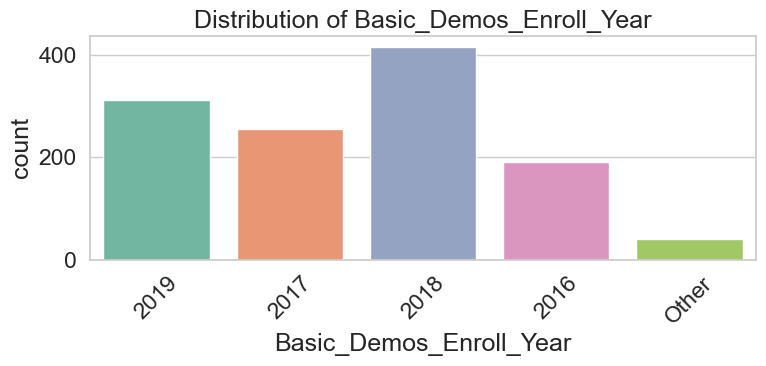

In [16]:
feature_1 = 'Basic_Demos_Enroll_Year'

threshold = 50

category_counts = train_combined[feature_1].value_counts()
rare_categories = category_counts[category_counts < threshold].index
train_combined[feature_1] = train_combined[feature_1].apply(
    lambda x: 'Other' if x in rare_categories else str(x)
)

test_combined[feature_1] = test_combined[feature_1].astype(str)
allowed_categories = set(train_combined[feature_1].unique())

test_combined[feature_1] = test_combined[feature_1].apply(
    lambda x: x if x in allowed_categories else 'Other'
)

plt.figure(figsize=(8, 4))
sns.countplot(data=train_combined, x='Basic_Demos_Enroll_Year', palette='Set2')
plt.title(f"Distribution of {feature_1}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

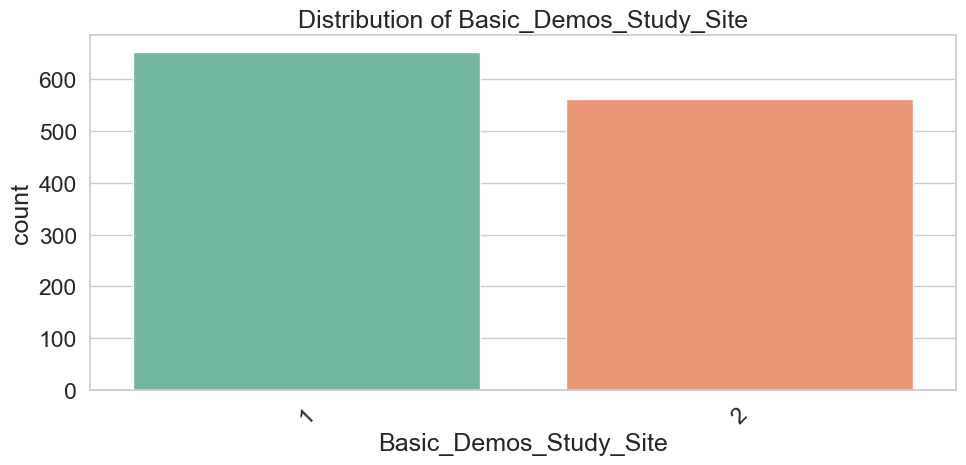

In [18]:
# Could collapse into only 2 classes 
feature_2 = 'Basic_Demos_Study_Site'
train_combined[feature_2] = train_combined[feature_2].replace({3: 2, 4: 2})
test_combined[feature_2] = test_combined[feature_2].replace({3: 2, 4: 2})

plt.figure(figsize=(10, 5))
sns.countplot(data=train_combined, x='Basic_Demos_Study_Site', palette='Set2')
plt.title(f"Distribution of {feature_2}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

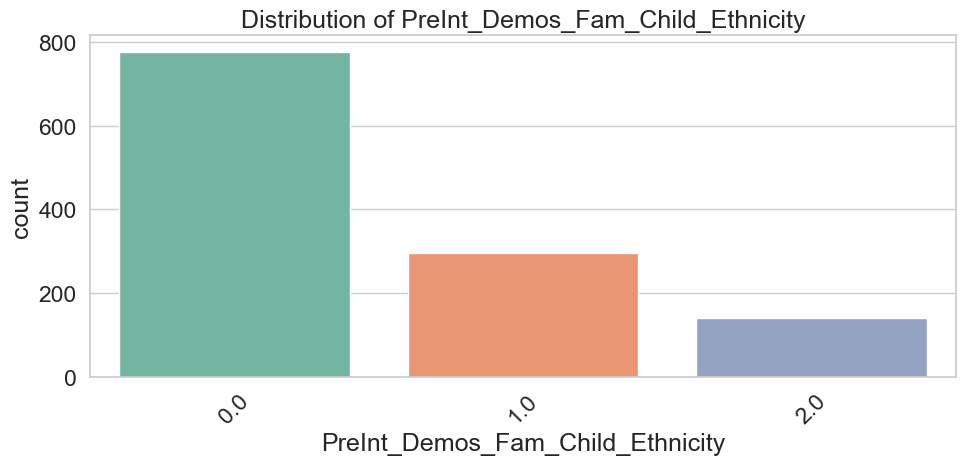

In [19]:
feature_3 = "PreInt_Demos_Fam_Child_Ethnicity"
train_combined[feature_3] = train_combined[feature_3].fillna(3.0)
test_combined[feature_3] = test_combined[feature_3].fillna(3.0)

train_combined[feature_3] = train_combined[feature_3].replace({3: 2})
test_combined[feature_3] = test_combined[feature_3].replace({3: 2})

plt.figure(figsize=(10, 5))
sns.countplot(data=train_combined, x='PreInt_Demos_Fam_Child_Ethnicity', palette='Set2')
plt.title(f"Distribution of {feature_3}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

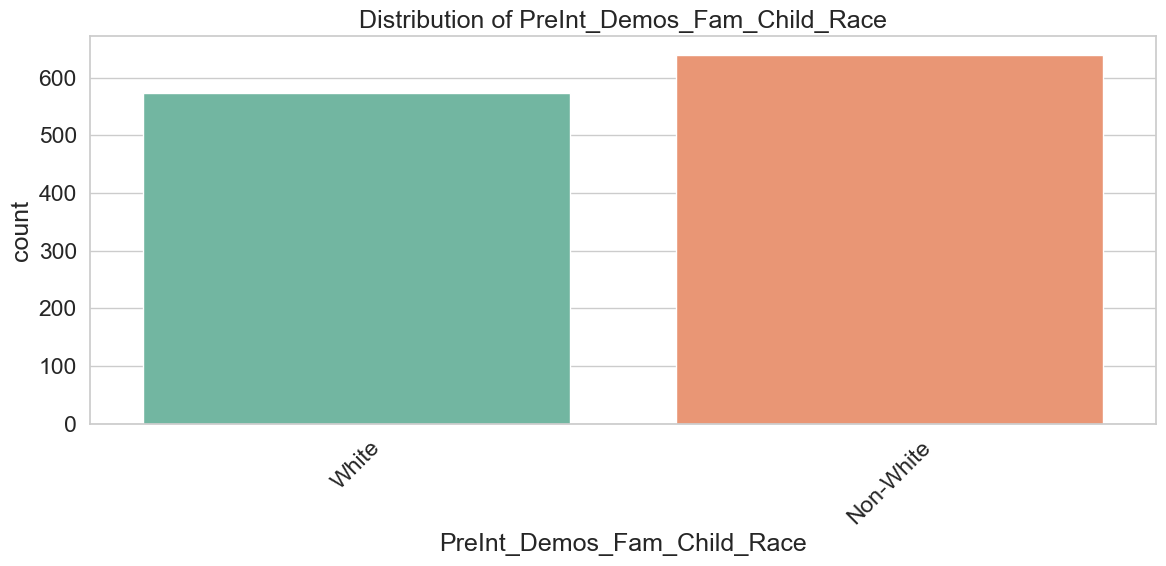

In [20]:
feature_4 = 'PreInt_Demos_Fam_Child_Race'
train_combined[feature_4] = train_combined[feature_4].fillna(10.0)
test_combined[feature_4] = test_combined[feature_4].fillna(10.0)

train_combined[feature_4] = train_combined[feature_4].apply(
    lambda x: "White" if x == 0.0 else "Non-White"
)

test_combined[feature_4] = test_combined[feature_4].apply(
    lambda x: 'White' if x == 0.0 else 'Non-White'
)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x='PreInt_Demos_Fam_Child_Race', palette='Set2')
plt.title(f"Distribution of {feature_4}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

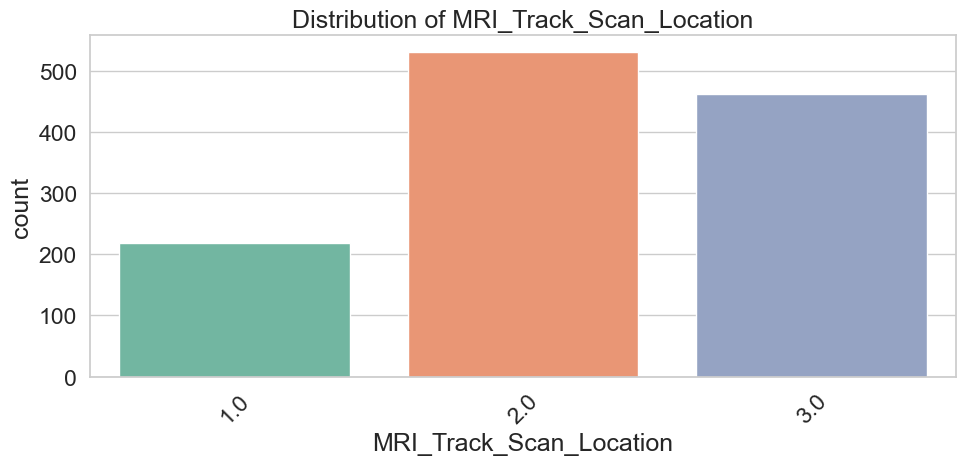

In [21]:
feature_5 = "MRI_Track_Scan_Location"
train_combined[feature_5] = train_combined[feature_5].fillna(4.0)   
test_combined[feature_5] = test_combined[feature_5].fillna(4.0)

train_combined[feature_5] = train_combined[feature_5].replace({4: 1})
test_combined[feature_5] = test_combined[feature_5].replace({4: 1})

plt.figure(figsize=(10, 5))
sns.countplot(data=train_combined, x='MRI_Track_Scan_Location', palette='Set2')
plt.title(f"Distribution of {feature_5}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

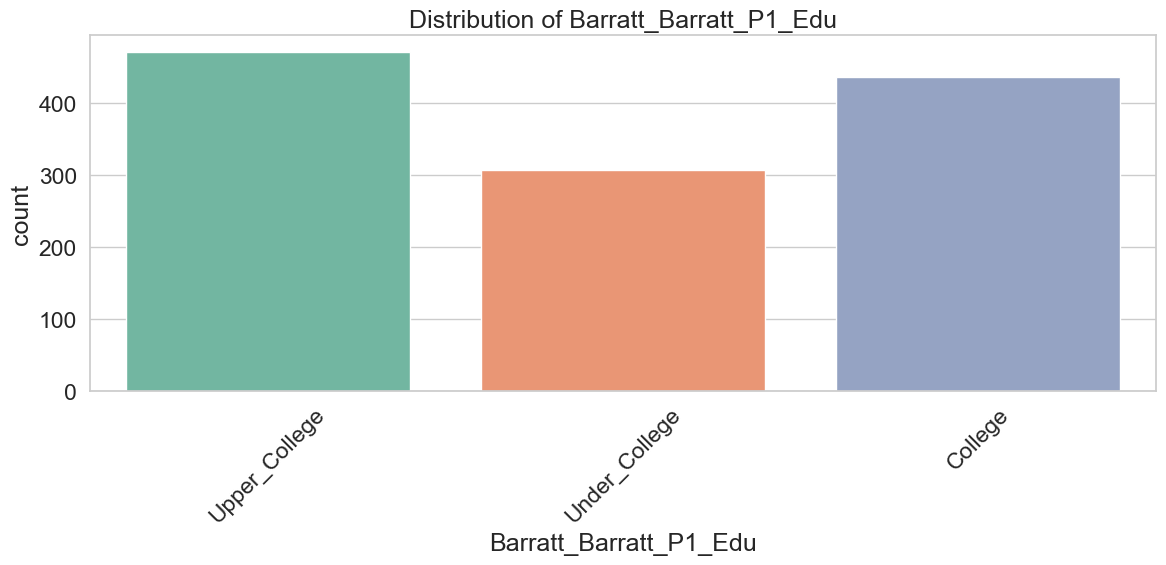

In [22]:
feature_6 = "Barratt_Barratt_P1_Edu"
train_combined[feature_6] = train_combined[feature_6].fillna(18.0)
test_combined[feature_6] = test_combined[feature_6].fillna(18.0)

def collapse_edu(value):
    if value == 21.0:
        return "Upper_College"
    elif value == 18.0:
        return "College"
    else:
        return "Under_College"
    
train_combined[feature_6] = train_combined[feature_6].apply(collapse_edu)
test_combined[feature_6] = test_combined[feature_6].apply(collapse_edu)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x="Barratt_Barratt_P1_Edu", palette='Set2')
plt.title(f"Distribution of {feature_6}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
feature_7 = "Barratt_Barratt_P1_Occ"

median_train_value = train_combined[feature_7].median()
median_test_value = test_combined[feature_7].median()

train_combined[feature_7] = train_combined[feature_7].fillna(median_train_value)
test_combined[feature_7] = test_combined[feature_7].fillna(median_test_value)

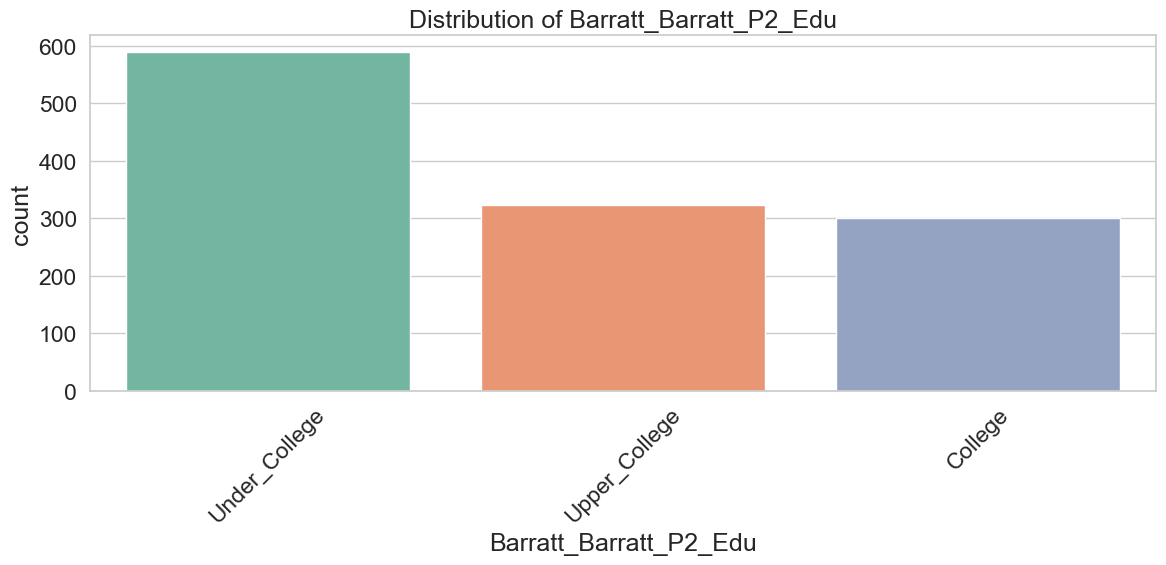

In [24]:
feature_8 = "Barratt_Barratt_P2_Edu"

train_combined[feature_8] = train_combined[feature_8].apply(collapse_edu)
test_combined[feature_8] = test_combined[feature_8].apply(collapse_edu)

def impute_p2_edu(row):
    if pd.isna(row['Barratt_Barratt_P2_Edu']):
        return row['Barratt_Barratt_P1_Edu']
    return row['Barratt_Barratt_P2_Edu']

train_combined['Barratt_Barratt_P2_Edu'] = train_combined.apply(impute_p2_edu, axis=1)
test_combined['Barratt_Barratt_P2_Edu'] = test_combined.apply(impute_p2_edu, axis=1)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x="Barratt_Barratt_P2_Edu", palette='Set2')
plt.title(f"Distribution of {feature_8}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
feature_9 = "Barratt_Barratt_P2_Occ"

def impute_p2_occ(row):
    if pd.isna(row['Barratt_Barratt_P2_Occ']):
        return row['Barratt_Barratt_P1_Occ']
    return row['Barratt_Barratt_P2_Occ']

train_combined[feature_9] = train_combined.apply(impute_p2_occ, axis=1)
test_combined[feature_9] = test_combined.apply(impute_p2_occ, axis=1)

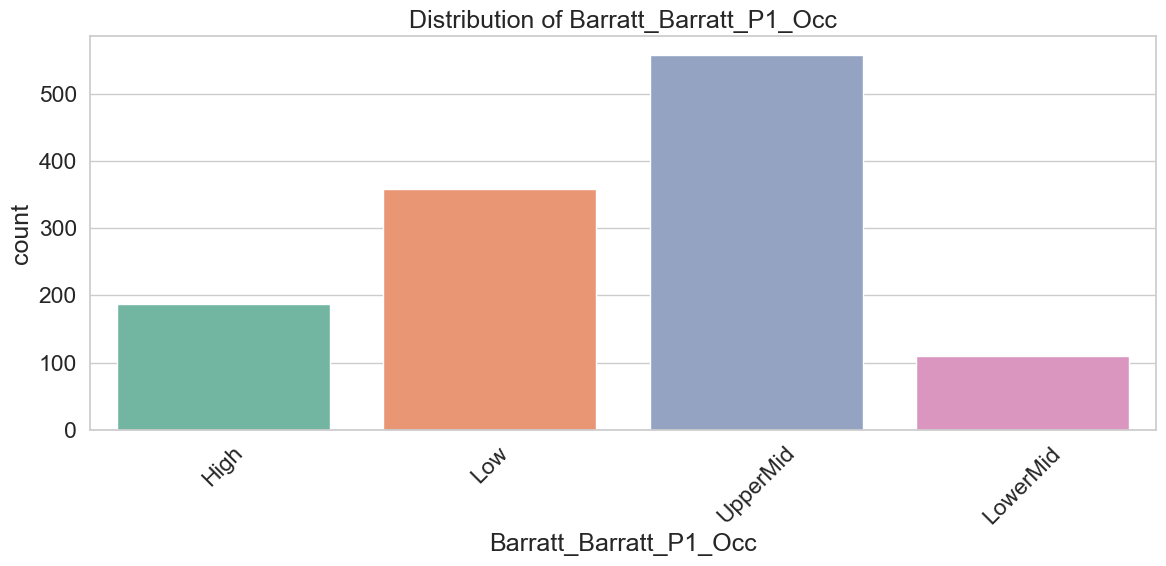

In [26]:
def collapse_occupation(val):
    if val in [0.0, 5.0, 10.0, 15.0]:
        return "Low"
    elif val in [20.0, 25.0]:
        return "LowerMid"
    elif val in [30.0, 35.0, 40.0]:
        return "UpperMid"
    elif val == 45.0:
        return "High"
    else:
        return "Other"  # Safety fallback
    
train_combined[feature_7] = train_combined[feature_7].apply(collapse_occupation)
test_combined[feature_7] = test_combined[feature_7].apply(collapse_occupation)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x="Barratt_Barratt_P1_Occ", palette='Set2')
plt.title(f"Distribution of {feature_7}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

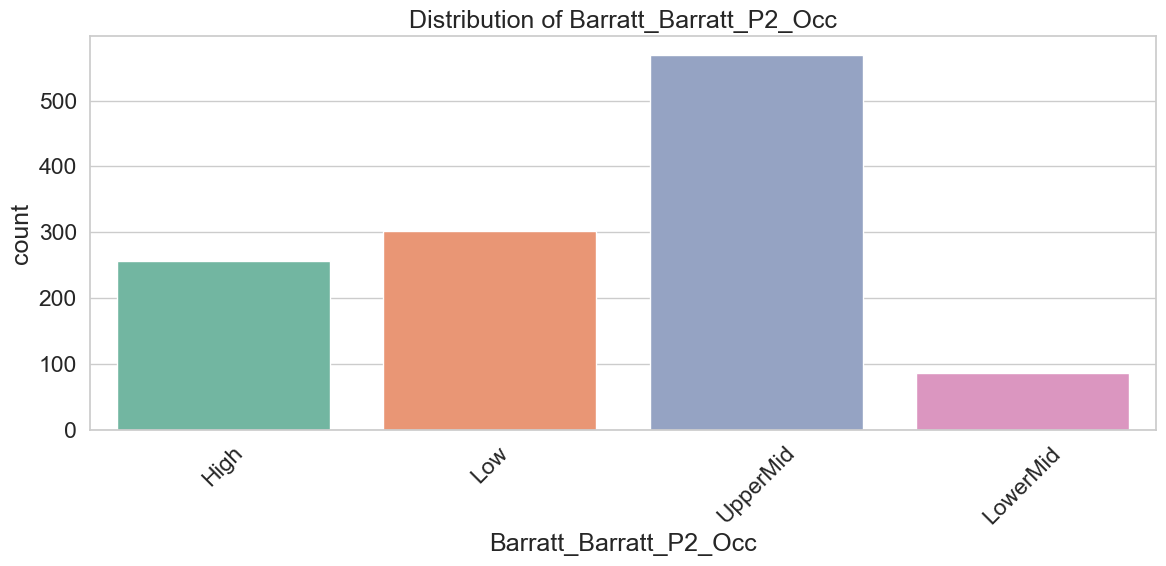

In [27]:
train_combined[feature_9] = train_combined[feature_9].apply(collapse_occupation)
test_combined[feature_9] = test_combined[feature_9].apply(collapse_occupation)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x="Barratt_Barratt_P2_Occ", palette='Set2')
plt.title(f"Distribution of {feature_9}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# label_encode_features = [
#     'Basic_Demos_Enroll_Year',
#     'Barratt_Barratt_P1_Edu',
#     'Barratt_Barratt_P1_Occ',
#     'Barratt_Barratt_P2_Edu',
#     'Barratt_Barratt_P2_Occ',
#     'Laterality_Category'
# ]

# from sklearn.preprocessing import LabelEncoder

# encoders = {}  # Store encoders if needed for inverse_transform later

# for feature in label_encode_features:
#     le = LabelEncoder()
#     train_combined[feature] = le.fit_transform(train_combined[feature])
#     test_combined[feature] = le.transform(test_combined[feature])
#     encoders[feature] = le  # Save encoder
    
# # Updated binary map: White = 1, Non-White = 0
# binary_map = {
#     'White': 1,
#     'Non-White': 0,
# }

# # Apply to 'PreInt_Demos_Fam_Child_Race'
# train_combined['PreInt_Demos_Fam_Child_Race'] = train_combined['PreInt_Demos_Fam_Child_Race'].map(binary_map)
# test_combined['PreInt_Demos_Fam_Child_Race'] = test_combined['PreInt_Demos_Fam_Child_Race'].map(binary_map)

In [28]:
# One-hot encode nominal features
nominal_cols = [
    'Basic_Demos_Enroll_Year',
    'Basic_Demos_Study_Site',
    'PreInt_Demos_Fam_Child_Ethnicity',
    'PreInt_Demos_Fam_Child_Race',
    'MRI_Track_Scan_Location',
    'Laterality_Category'
]

train_combined = pd.get_dummies(train_combined, columns=nominal_cols, drop_first=True, dtype=int)
test_combined = pd.get_dummies(test_combined, columns=nominal_cols, drop_first=True, dtype=int)

# Align columns
train_combined, test_combined = train_combined.align(test_combined, join='left', axis=1, fill_value=0)

In [29]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_map = {
    'Barratt_Barratt_P1_Edu': ['Under_College', 'College', 'Upper_College'],
    'Barratt_Barratt_P2_Edu': ['Under_College', 'College', 'Upper_College'],
    'Barratt_Barratt_P1_Occ': ['Low', 'LowerMid', 'UpperMid', 'High'],
    'Barratt_Barratt_P2_Occ': ['Low', 'LowerMid', 'UpperMid', 'High']
}

ordinal_cols = list(ordinal_map.keys())
categories = [ordinal_map[col] for col in ordinal_cols]

encoder = OrdinalEncoder(categories=categories)

train_combined[ordinal_cols] = encoder.fit_transform(train_combined[ordinal_cols])
test_combined[ordinal_cols] = encoder.transform(test_combined[ordinal_cols])

In [30]:
train_combined.reset_index(inplace=True)
test_combined.reset_index(inplace=True)

In [ ]:
# train_combined.to_csv("train_processed_ver2.csv", index=False)
# test_combined.to_csv("test_processed_ver2.csv", index=False)

# 3. Feature Engineering (Model-Agnostic)

## Inter-feature correlation 
You might keep only one feature from a highly correlated group, perhaps the one more strongly correlated with the targets or based on domain knowledge. This is particularly important for Logistic Regression which is sensitive to multicollinearity.

+ Covariance matrix: symmetric and positive semidefinite and tells us about the spread of the data => Plot the correlation matrix

## Correlation with targets
+ (Numerical features): The Pearson's correlation coefficient is often used, which is a normalized version of covariance that ranges from -1 to +1, providing a more standardized measure of the strength and direction of the linear relationship. This indicator only captures the linear relationship between variables. It is worth noting that when categorical features are encoded and they are NOMIAL, a low p-value might not reflect fully its influence
Solution: non-linear transformation, interaction features, feature combinations (arithmetic), domain knowledge 

+ (Numerical and categorical features) Mutual information: Captures the statistical dependence between two random variables. Unlike correlation, MI can capture both linear and non-linear relationships. A higher MI score indicates a stronger dependency between the nominal feature and the categorical target.

## Statistical Tests
+ ANOVA F-test: For numerical features vs. each categorical target. Tests if the mean of the numerical feature differs significantly across the target groups (e.g., mean age for ADHD vs. non-ADHD). A significant p-value suggests relevance.

+ Chi-Squared Test: For categorical features (like `PreInt_Demos_Fam_Child_Race`, `Laterality_Category`) vs. each categorical target. Tests for independence between the feature and the target. A significant p-value suggests dependence/relevance.

## Solution
Variance Threshold: Remove features with very low variance. These features are nearly constant and thus provide little predictive information. Be cautious with numerical features if they haven't been scaled.

A feature might be considered important if it shows relevance (high correlation/MI, significant test) to either `ADHD_Outcome` or `Sex_F`. You can rank features based on their scores for each target and combine the rankings or set thresholds.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif, mutual_info_classif
from scipy.stats import pointbiserialr
import warnings
warnings.filterwarnings("ignore")
# Set visual style
sns.set_theme(style="whitegrid")
%matplotlib inline
SEED  = 42

In [32]:
train_metadata = pd.read_csv('train_processed_ver2.csv').set_index("participant_id")
test_metadata = pd.read_csv('test_processed_ver2.csv').set_index("participant_id")

train_fmri = pd.read_csv("train_fMRI.csv").set_index("participant_id")  
train_fmri = train_fmri.drop(columns=["Unnamed: 0"], axis=1)

test_fmri = pd.read_csv("test_fMRI.csv").set_index("participant_id")    
test_fmri = test_fmri.drop(columns=["Unnamed: 0"], axis=1)


train_combined = train_metadata.join(train_fmri, how='left')
test_combined = test_metadata.join(test_fmri, how='left')

labels = pd.read_excel("data/TRAIN/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")

train_combined = train_combined.sort_index()
test_combined = test_combined.sort_index()
labels = labels.sort_index()

assert all(train_combined.index == labels.index), "Label IDs do not match train_combined IDs"

y_train_sex = labels['Sex_F']
y_train_adhd = labels['ADHD_Outcome']

print("Merged Training Data Shape:", train_combined.shape)
print("Merged Test Data Shape:", test_combined.shape)

Merged Training Data Shape: (1213, 66)
Merged Test Data Shape: (304, 66)


In [33]:
train_combined.columns

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ',
       'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ',
       'Basic_Demos_Enroll_Year_2017', 'Basic_Demos_Enroll_Year_2018',
       'Basic_Demos_Enroll_Year_2019', 'Basic_Demos_Enroll_Year_Other',
       'Basic_Demos_Study_Site_2', 'PreInt_Demos_Fam_Child_Ethnicity_1.0',
       'PreInt_Demos_Fam_Child_Ethnicity_2.0',
       'PreInt_Demos_Fam_Child_Race_White', 'MRI_Track_Scan_Location_2.0',
       'MRI_Track_Scan_Location_3.0', 'Laterality_Category_Middle',
       'Lat

These are the correlation (normalised), p-value, and mutual information

In [34]:
F_sex, p_sex = f_classif(train_combined, y_train_sex)
mi_sex = mutual_info_classif(train_combined, y_train_sex, random_state=SEED)

F_adhd, p_adhd = f_classif(train_combined, y_train_adhd)
mi_adhd = mutual_info_classif(train_combined, y_train_adhd, random_state=SEED)

corr_sex = []
corr_adhd = []

for feature in train_combined.columns:
    try:
        corr_s, _ = pointbiserialr(train_combined[feature], y_train_sex)
        corr_a, _ = pointbiserialr(train_combined[feature], y_train_adhd)
    except:
        corr_s, corr_a = float('nan'), float('nan')
    corr_sex.append(corr_s)
    corr_adhd.append(corr_a)
    
    
features = train_combined.columns

df_sex = pd.DataFrame({
    "feature": features,
    "MI": mi_sex,
    # "F_stat": F_sex,
    "p_value": p_sex,
    "correlation": [abs(i) for i in corr_sex]
}).sort_values(by="p_value", ascending=True)

df_adhd = pd.DataFrame({
    "feature": features,
    "MI": mi_adhd,
    # "F_stat": F_adhd,
    "p_value": p_adhd,
    "correlation": [abs(i) for i in corr_adhd]
}).sort_values(by="p_value", ascending=True)

In [35]:
df_sex.head(20)

,feature,MI,p_value,correlation
13,SDQ_SDQ_Hyperactivity,0.001716,8.508961e-07,0.140801
16,SDQ_SDQ_Prosocial,0.000000,1.686387e-05,0.123200
11,SDQ_SDQ_Externalizing,0.000000,2.732560e-05,0.120127
10,SDQ_SDQ_Emotional_Problems,0.025504,1.692720e-04,0.107782
1,ColorVision_CV_Score,0.000000,2.374002e-04,0.105347
7,APQ_P_APQ_P_PP,0.000000,1.549670e-02,0.069488
53,19,0.000000,1.921018e-02,0.067221
4,APQ_P_APQ_P_INV,0.000000,2.605546e-02,0.063897
44,10,0.009166,2.739996e-02,0.063335
21,Barratt_Barratt_P2_Occ,0.000000,3.137199e-02,0.061803


In [36]:
df_adhd.head(20)

,feature,MI,p_value,correlation
13,SDQ_SDQ_Hyperactivity,0.168587,6.190438e-99,0.554996
11,SDQ_SDQ_Externalizing,0.174188,7.469973e-82,0.511544
9,SDQ_SDQ_Difficulties_Total,0.152288,2.714082e-65,0.462403
12,SDQ_SDQ_Generating_Impact,0.111656,6.055412e-50,0.408330
8,SDQ_SDQ_Conduct_Problems,0.026890,2.238522e-22,0.274289
14,SDQ_SDQ_Internalizing,0.028370,1.104110e-19,0.256546
15,SDQ_SDQ_Peer_Problems,0.040492,1.375417e-14,0.218593
10,SDQ_SDQ_Emotional_Problems,0.043764,5.723628e-13,0.204939
16,SDQ_SDQ_Prosocial,0.013181,2.577512e-11,0.189930
5,APQ_P_APQ_P_OPD,0.030508,8.442416e-07,0.140844


In [38]:
# Filter the DataFrame for features with p-value < 0.05 and abs(correlation) > 0.1
df_sex_filtered = df_sex[(df_sex["p_value"] < 0.05) & (df_sex["correlation"].abs() > 0.05)]
print(df_sex_filtered['feature'].tolist())
print(len(df_sex_filtered['feature'].tolist()))

['SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Prosocial', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Emotional_Problems', 'ColorVision_CV_Score', 'APQ_P_APQ_P_PP', '19', 'APQ_P_APQ_P_INV', '10', 'Barratt_Barratt_P2_Occ', 'APQ_P_APQ_P_OPD', 'Barratt_Barratt_P1_Edu', '17', 'SDQ_SDQ_Internalizing']
14


In [39]:
df_adhd_filtered = df_adhd[(df_adhd["p_value"] < 0.05) & (df_adhd["correlation"].abs() > 0.1)]
print(df_adhd_filtered['feature'].tolist())
print(len(df_adhd_filtered['feature'].tolist()))

['SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Prosocial', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_ID', 'MRI_Track_Scan_Location_3.0', 'Basic_Demos_Enroll_Year_2018']
13


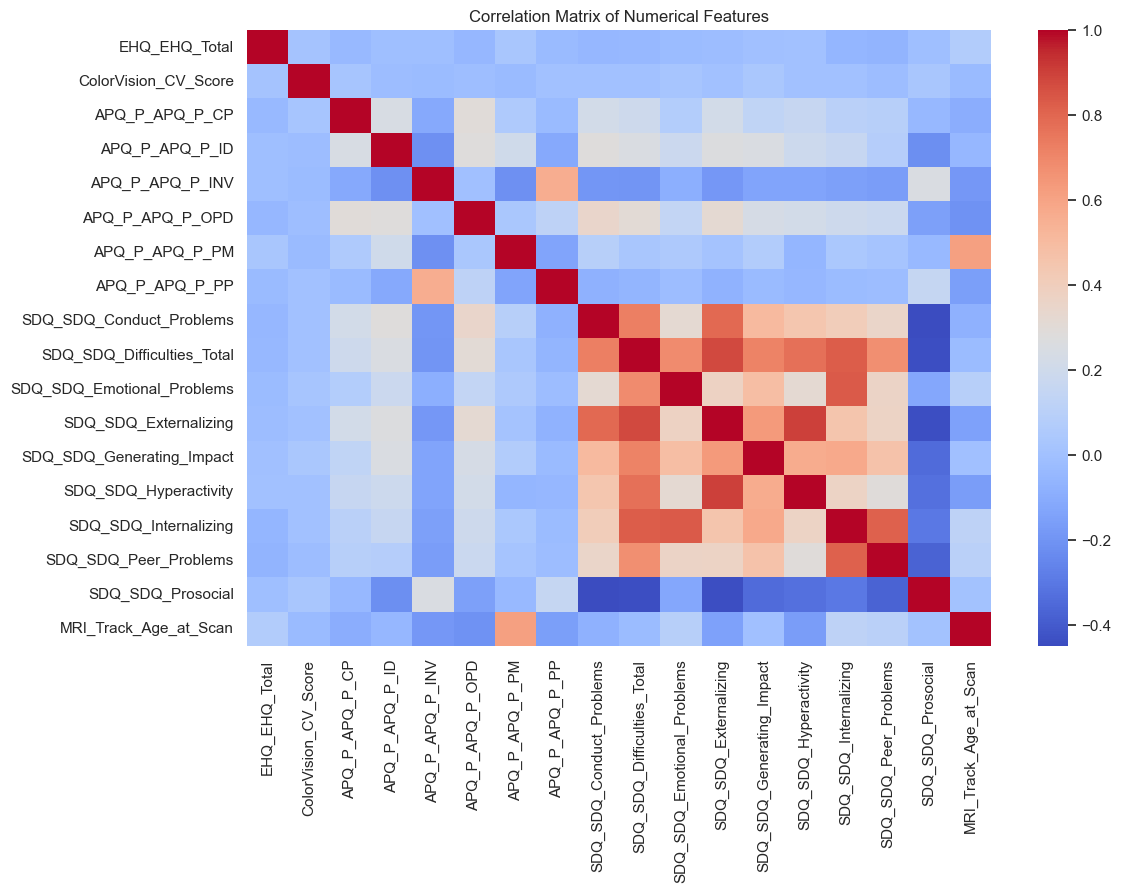

In [40]:
# Correlation Matrix
numerical_features = ['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
    'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
]
correlation_matrix = train_combined[numerical_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# 3.5: Feature Engineering (Model-Specific)

+ Recursive Feature Elimination (RFE): Starts with all features, trains a model (e.g., Logistic Regression, SVM, or a Tree-based model), removes the least important feature(s) based on coefficients or feature importance scores, and repeats until the desired number of features is reached. The importance is evaluated based on the model's performance on a validation set using the weighted F1 score.

+ Sequential Feature Selection (SFS): Forward Selection: Starts with no features, iteratively adds the feature that results in the best model performance (using the weighted F1 score) until no further improvement is seen.
OR
Backward Elimination: Starts with all features, iteratively removes the feature whose removal least degrades (or most improves) model performance (using the weighted F1 score).

## Embedded Methods (Model-Integrated) 
+ L1 Regularization (Lasso): Used with linear models like Logistic Regression. Adds a penalty proportional to the absolute value of the coefficients. This forces some coefficients to become exactly zero, effectively1 removing those features from the model. You can train a Logistic Regression model with L1 penalty and select the features with non-zero coefficients.   

+ Tree-Based Feature Importance: Models like Random Forest, Gradient Boosting Machines (XGBoost, LightGBM, CatBoost) naturally compute feature importance scores during training (e.g., based on Gini impurity reduction or the number of times a feature is used to split). Train a multi-output tree-based model and use these importance scores to rank and select features. Features with low importance can be dropped.

# 4. Modeling 

+ Logistic Regression: likely to converge to a point due to its simplistic architecture, despite how many feature engineering you did 

+ MLP: The depth of the network allows for hierarchical feature learning, which is particularly useful for complex non-linearities. Each layer the model learns new features, but it is a black box and we as humans cannot interpret what those features are

+ Tree-based algorithm: Gradient Boosting Machines (GBM) (e.g., XGBoost, LightGBM, CatBoost): These are also ensemble methods that build trees sequentially, with each new tree trying to correct the errors made by the previous ones. They are highly effective at capturing intricate non-linear patterns and often achieve state-of-the-art performance

+ Support Vector Machines with non-linear kernels: By using kernel functions (like Radial Basis Function (RBF), polynomial, or sigmoid), SVMs can implicitly map the data into a higher-dimensional space where it might become linearly separable. This allows them to learn complex non-linear decision boundaries in the original feature space

In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, brier_score_loss
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from scipy.stats import ks_2samp, mannwhitneyu

import warnings
warnings.filterwarnings("ignore")

SEED = 42
REPEATS = 5
FOLDS = 5

In [ ]:
train_metadata = pd.read_csv('train_processed_ver2.csv').set_index("participant_id")
test_metadata = pd.read_csv('test_processed_ver2.csv').set_index("participant_id")

train_fmri = pd.read_csv("train_fMRI.csv").set_index("participant_id")  
train_fmri = train_fmri.drop(columns=["Unnamed: 0"], axis=1)

test_fmri = pd.read_csv("test_fMRI.csv").set_index("participant_id")    
test_fmri = test_fmri.drop(columns=["Unnamed: 0"], axis=1)


train_combined = train_metadata.join(train_fmri, how='left')
test_combined = test_metadata.join(test_fmri, how='left')

labels = pd.read_excel("data/TRAIN/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")

train_combined = train_combined.sort_index()
test_combined = test_combined.sort_index()
labels = labels.sort_index()

y_adhd = labels['ADHD_Outcome']
y_sex = labels['Sex_F']
combinations = y_adhd.astype(str) + y_sex.astype(str)

assert all(train_combined.index == labels.index), "Label IDs do not match train_combined IDs"

print("Merged Training Data Shape:", train_combined.shape)
print("Merged Test Data Shape:", test_combined.shape)

def eval_metrics(y_true, y_pred, weights, label="None", threshold=0.6):
    brier = brier_score_loss(y_true, y_pred)
    f1 = f1_score(y_true, (y_pred > threshold).astype(int), sample_weight=weights)
    print(f"{label} -> Brier Score: {brier:.4f}, F1: {f1:.4f}")
    return brier, f1

In [ ]:
train_combined.columns

In [ ]:
numerical_cols = ['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31'
]

ordinal_categorical_cols = ['Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']

categorical_cols = [col for col in train_combined.columns if col not in numerical_cols]

columns_to_scale = numerical_cols + ordinal_categorical_cols

In [ ]:
ct = ColumnTransformer(
    transformers=[
        ('num_ord_scaler', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # keep other columns (like one-hot) as-is
)

X_train = ct.fit_transform(train_combined)
X_test = ct.transform(test_combined)

In [ ]:
remaining_col_names = [col for col in train_combined.columns if col not in columns_to_scale]

final_col_names = columns_to_scale + remaining_col_names

train_combined = pd.DataFrame(X_train, columns=final_col_names, index=train_combined.index)
test_combined = pd.DataFrame(X_test, columns=final_col_names, index=test_combined.index)

In [ ]:
features_sex = ['SDQ_SDQ_Hyperactivity',
'SDQ_SDQ_Prosocial',
'SDQ_SDQ_Externalizing',
'SDQ_SDQ_Emotional_Problems',
'ColorVision_CV_Score',
'APQ_P_APQ_P_PP',
'19',
'APQ_P_APQ_P_INV',
'10',
'Barratt_Barratt_P2_Occ',
'APQ_P_APQ_P_OPD',
'Barratt_Barratt_P1_Edu',
'17',
'SDQ_SDQ_Internalizing',
'4',
'Basic_Demos_Study_Site_2',
'SDQ_SDQ_Conduct_Problems',
'18',
'Basic_Demos_Enroll_Year_2019',
'20']

features_adhd = ['SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Prosocial', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_ID', 'MRI_Track_Scan_Location_3.0', 'Basic_Demos_Enroll_Year_2018']

In [ ]:
train_combined.head(2)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
skf = StratifiedKFold(n_splits=FOLDS)

# Define weighted F1 scorer
def weighted_f1(y_true, y_pred):
    weights = np.where((y_true == 1) & (labels['Sex_F'].loc[y_true.index] == 1), 2, 1)
    return f1_score(y_true, (y_pred > 0.5).astype(int), sample_weight=weights)

weighted_f1_scorer = make_scorer(weighted_f1, needs_proba=True)

#### CATBOOST ####
param_grid_catboost = {
    'iterations': [100, 200],  # Or other relevant values
    'learning_rate': [0.01, 0.03, 0.1],  # Or other relevant values
    'depth': [4, 6, 8],  # Or other relevant values
    'l2_leaf_reg': [1, 3, 5],  # Or other relevant values
    'random_state': [SEED],
    'verbose': [0]
}

# catboost_model = CatBoostClassifier(task_type='GPU', devices='0') # Ensure GPU usage

catboost_model = CatBoostClassifier()

grid_search_sex = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid_catboost,
    scoring=weighted_f1_scorer,
    cv=rskf,
    n_jobs=1,  # Reduced n_jobs
)

#### LOGISTIC REGRESSION ####
params = {
    "penalty": "l1",
    "Cs": 10,
    "cv": skf,
    "fit_intercept": True,
    "scoring": "f1",
    "random_state": SEED,
    "solver": "saga",
    "class_weight": "balanced"  
}

model_adhd = LogisticRegressionCV(**params)

sex_oof_catboost = np.zeros(len(y_sex))
adhd_oof = np.zeros(len(y_adhd))
scores_sex_catboost = []
scores_adhd = []

t_adhd = 0.4 

In [ ]:
for fold, (train_idx, val_idx) in enumerate(rskf.split(train_combined, combinations), 1):
    print(f"\n=== Fold {fold} (CatBoost for Sex) ===")
    X_train_fold, X_val_fold = train_combined.iloc[train_idx].copy(), train_combined.iloc[val_idx].copy()
    y_train_adhd_fold, y_val_adhd_fold = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]
    y_train_sex_fold, y_val_sex_fold = y_sex.iloc[train_idx], y_sex.iloc[val_idx]

    # Sample weights: 2x weight for "11" (female ADHD) cases
    weights_train_fold = np.where(combinations.iloc[train_idx] == "11", 2, 1)
    weights_val_fold = np.where(combinations.iloc[val_idx] == "11", 2, 1)

    # ----- First Stage: ADHD Model (Keep as is) -----
    model_adhd.fit(X_train_fold[features_adhd], y_train_adhd_fold, sample_weight=weights_train_fold)
    adhd_val_fold = model_adhd.predict_proba(X_val_fold[features_adhd])[:, 1]
    adhd_brier, adhd_f1 = eval_metrics(y_val_adhd_fold, adhd_val_fold, weights_val_fold, "ADHD", t_adhd)

    # ----- Second Stage: Sex Model (CatBoost with Grid Search) -----
    grid_search_sex.fit(X_train_fold[features_sex], y_train_sex_fold, sample_weight=weights_train_fold)
    best_catboost_model = grid_search_sex.best_estimator_
    sex_val_catboost = best_catboost_model.predict_proba(X_val_fold[features_sex])[:, 1]
    sex_oof_catboost[val_idx] += sex_val_catboost / REPEATS

    # Evaluate CatBoost model
    sex_brier_catboost, sex_f1_catboost = eval_metrics(y_val_sex_fold, sex_val_catboost, weights_val_fold, "Sex_F (CatBoost)")
    scores_sex_catboost.append((sex_brier_catboost, sex_f1_catboost))

print(f"\n=== CV Results (CatBoost for Sex) ===")
print(f"Sex Mean Brier Score (CatBoost): {np.mean([s[0] for s in scores_sex_catboost]):.4f}")
print(f"Sex Mean F1 (CatBoost): {np.mean([s[1] for s in scores_sex_catboost]):.4f}")
print(f"ADHD Mean Brier Score (Logistic Regression): {np.mean([s[0] for s in scores_adhd]):.4f}")
print(f"ADHD Mean F1 (Logistic Regression): {np.mean([s[1] for s in scores_adhd]):.4f}")

In [ ]:
best_catboost_model.get_feature_importance()

In [ ]:
weights_full = np.where(combinations == "11", 2, 1)

# Train final Logistic Regression model for ADHD
final_model_adhd = LogisticRegressionCV(**params)
final_model_adhd.fit(train_combined[features_adhd], y_adhd, sample_weight=weights_full)
adhd_proba_test_final = final_model_adhd.predict_proba(test_combined[features_adhd])[:, 1]

# Train final CatBoost model for Sex using the best parameters found by grid search
final_model_sex_catboost = grid_search_sex.best_estimator_
final_model_sex_catboost.fit(train_combined[features_sex], y_sex, sample_weight=weights_full)
sex_proba_test_final_catboost = final_model_sex_catboost.predict_proba(test_combined[features_sex])[:, 1]

# Threshold optimization for OOF predictions (using CatBoost OOF for sex)
thresholds = np.linspace(0, 1, 100)

# ADHD threshold optimization (using existing OOF predictions)
adhd_scores = [f1_score(y_adhd, (adhd_oof > t).astype(int), sample_weight=weights_full) for t in thresholds]
best_adhd_threshold = thresholds[np.argmax(adhd_scores)]

# Sex threshold optimization (using CatBoost OOF predictions)
sex_scores_catboost_oof = [f1_score(y_sex, (sex_oof_catboost > t).astype(int), sample_weight=weights_full) for t in thresholds]
best_sex_threshold_catboost = thresholds[np.argmax(sex_scores_catboost_oof)]

# 5. Inference / Evaluation

In [ ]:
# Create submission file
submission_catboost = pd.read_excel("data/SAMPLE_SUBMISSION.xlsx")
submission_catboost["ADHD_Outcome"] = np.where(adhd_proba_test_final > best_adhd_threshold, 1, 0)
submission_catboost["Sex_F"] = np.where(sex_proba_test_final_catboost > best_sex_threshold_catboost, 1, 0)

# Compare share of predicted labels at thresholds between OOF and Test (for CatBoost Sex)
print(f"Share ADHD OOF: {np.mean(np.where(adhd_oof > best_adhd_threshold, 1, 0)):.4f} - Share ADHD Test: {submission_catboost.ADHD_Outcome.mean():.4f}")
print(f"Share Sex_F OOF (CatBoost): {np.mean(np.where(sex_oof_catboost > best_sex_threshold_catboost, 1, 0)):.4f} - Share Sex_F Test (CatBoost): {submission_catboost.Sex_F.mean():.4f}")

submission_catboost.to_csv("submission_catboost.csv", index=False)

print("\nCatBoost grid search complete and submission file generated.")
print("Best parameters found for CatBoost (Sex):", grid_search_sex.best_params_)